# Model of hemispherical sensor for PV field

Calculates % of cover of PV panels, shade and soil based on a simulated hemispherical sensor measuring at a 45° angle downwards

The following parameters are required:
- distance between panels ($d = d_{sh} + d_{so}$), where $d_{sh}$ is the shade length, and $d_{so}$ is the sun-exposed soil length
- nadir-length of panels ($l_{pv}$)
- angle of panel installation ($\alpha_{pv}$): 30°
- height of mast ($h_m$)

Each panel measures 5m by 2m with a width of 0.05m. The height between the top of the panel and the ground is 3m, and the bottom is 0.5m above ground. The gap between each of the lines of panels is 5m, and the inclination angle is 30°.

In [1]:
import pandas as pd
import numpy as np
import glob

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
# Data taken from summer-time 12:30

# Panel
l_pv_p   = 46.5        # Length from nadir (%)
alpha_pv = 30.0        # Angle of installation (degrees)
h_struct = 0.5         # Height of panel structure above ground (m)
h_pv     = 2.5         # Height of panels withouth structure (m)
L_pv     = 5.0         # Length of panels (m)
l_pv     = np.cos(np.radians(alpha_pv))*L_pv # Length from nadir (m)
h_panels = h_struct + np.sin(np.radians(alpha_pv)) * L_pv # Height of panels with structure

# Space between panels
d_sh_p   =  6.5        # Shade length (%)
d_so_p   = 47.0        # Sun-exposed soil length (%)
d_perc   = d_sh_p + d_so_p # Total distance between panels (%)
d_m      = 5.0         # Total distance between panels (m)
d_sh     = d_sh_p*d_m/(d_sh_p + d_so_p) # distance of shade (m)
d_so     = d_so_p*d_m/(d_sh_p + d_so_p) # distance of sun-exposed soil (m)

In [26]:
# Mast location: Edge of a panel

# In steps of degrees
def dist_from_mast(h_m, steps=1, viewing_ang=90):
    viewing_angle = viewing_ang
    # Calculate steps of ° increments below the mast
    d_from_mast = []
    for gamma in np.arange(-(viewing_angle/2),(viewing_angle/2)+1,steps):
        d_from_mast.append(np.tan(np.radians(gamma))*h_m)
    return(d_from_mast)

# Create a df for the position on the ground (in m), and classify as such
def create_ground_df(h_m, steps=0.5, viewing_ang=90):
    #ground_distance_from_mast = np.arange(-h_m, h_m, steps) # Equal steps of horizontal distance
    ground_distance_from_mast = dist_from_mast(h_m, steps=steps, viewing_ang=viewing_ang) # Equal steps of degrees of view of the sensor
    df = pd.DataFrame(data=ground_distance_from_mast,
                      columns=['ground_dist'])
    df['height'] = 0
    df['viewing'] = np.nan
    # Classify (right of mast)
    df['ground_class'] = np.nan
    category_name   = ['shade', 'soil', 'under_panel']
    category_length = [d_sh, d_so, l_pv]
    cur_cat = 0
    cur_ref_dist = category_length[cur_cat]
    for index, row in df.loc[df['ground_dist'] >= 0].iterrows():
        d = row['ground_dist']
        if(d > cur_ref_dist):
            # Switch category
            cur_cat += 1
            if(cur_cat >= len(category_name)):
                cur_cat = 0
            # Add to covered reference length
            cur_ref_dist += category_length[cur_cat]
        df.loc[df['ground_dist'] == d, 'ground_class'] = category_name[cur_cat]
        if(category_name[cur_cat] == 'under_panel'):
            current_height = (d - (cur_ref_dist-l_pv))*np.tan(np.radians(alpha_pv)) + 0.5
            df.loc[df['ground_dist'] == d, 'height'] = current_height
    # Classify (left of mast)
    category_name   = ['shade', 'soil', 'under_panel']
    category_length = [d_sh, d_so, l_pv]
    cur_cat = 2
    cur_ref_dist = -category_length[cur_cat]
    pd.DataFrame.reverse = lambda self: self[::-1] # Iterate through in reverse order
    for index, row in df.loc[df['ground_dist'] <= 0].reverse().iterrows():
        d = row['ground_dist']
        if(d < cur_ref_dist):
            # Switch category
            cur_cat -= 1
            if(cur_cat < 0):
                cur_cat = 2
            # Subtract from covered reference length
            cur_ref_dist -= category_length[cur_cat]
        df.loc[df['ground_dist'] == d, 'ground_class'] = category_name[cur_cat]
        if(category_name[cur_cat] == 'under_panel'):
            current_height = (d - cur_ref_dist)*np.tan(np.radians(alpha_pv)) + 0.5
            if(current_height < 0):
                current_height = -current_height
            df.loc[df['ground_dist'] == d, 'height'] = current_height
    return(df)

def check_interception_object(ground_df):
    df = ground_df.copy()
    # Classify (right of mast)
    list_prev = []
    for index, row in df.loc[df['ground_dist'] >= 0].iterrows():
        # Calculate for current angle and all future ones
        list_prev.append(row['ground_dist'])
        current_angle = np.arctan(row['ground_dist']/h_m)
        for current_dist in list_prev[::-1]:
            current_height = h_m - current_dist/np.tan(current_angle)
            if(df.loc[(df['ground_dist'] == current_dist), 'height'].values[0] > np.round(current_height,3)):
                df.loc[(df['ground_dist'] == row['ground_dist']), 'viewing'] = 'panel'
                break
            pass
        pass
    
    # Classify (left of mast)
    list_prev = []
    pd.DataFrame.reverse = lambda self: self[::-1] # Iterate through in reverse order
    for index, row in df.loc[df['ground_dist'] <= 0].reverse().iterrows():
        # Calculate for current angle and all future ones
        list_prev.append(row['ground_dist'])
        current_angle = np.arctan(row['ground_dist']/h_m)
        for current_dist in list_prev[::-1]:
            current_height = h_m - current_dist/np.tan(current_angle)
            if(row['ground_dist'] < 0):
                angle_at_height = np.arctan((h_m - row['height']) / -row['ground_dist'])
            else:
                angle_at_height = np.radians(89.999)
            if(((90+np.degrees(current_angle)) < alpha_pv) or (np.degrees(angle_at_height) < alpha_pv)):
                if(df.loc[(df['ground_dist'] == current_dist), 'height'].values[0] > np.round(current_height,3)):
                    df.loc[(df['ground_dist'] == row['ground_dist']), 'viewing'] = 'under_panel'
                    break
                else:
                    pass
            if(df.loc[(df['ground_dist'] == current_dist), 'height'].values[0] > np.round(current_height,3)):
                df.loc[(df['ground_dist'] == row['ground_dist']), 'viewing'] = 'panel'
                break
            pass
        pass
    
    df.loc[(df['viewing'].isna()), 'viewing'] = df.loc[(df['viewing'].isna()), 'ground_class']
    df.loc[df['ground_dist'] == 0, 'viewing'] = 'panel'
    
    # Remove points if they are higher than the viewing angle
    # Right of mast
    max_dist = np.round(df['ground_dist'].max(), 2)
    view_angle = np.arctan(max_dist/h_m)
    for index, row in df.loc[df['ground_dist'] >= 0].iterrows():
        current_beam_height = h_m - row['ground_dist']/np.tan(view_angle)
        if(row['height'] > np.round(current_beam_height,3)):
                df.loc[(df['ground_dist'] == row['ground_dist']), 'viewing'] = np.nan
    # Left of mast
    min_dist = np.round(df['ground_dist'].min(), 2)
    view_angle = np.arctan(min_dist/h_m)
    #print(view_angle)
    for index, row in df.loc[df['ground_dist'] <= 0].reverse().iterrows():
        current_beam_height = h_m - row['ground_dist']/np.tan(view_angle)
        if(row['height'] > np.round(current_beam_height,3)):
                df.loc[(df['ground_dist'] == row['ground_dist']), 'viewing'] = np.nan
    # Drop invisible points
    df.dropna(subset=['viewing'], inplace=True) 
    
    return(df)

def calculate_viewing_percentages(df):
    # count by category:
    n_tot = len(df.index)
    n_df = df.groupby(['viewing']).count()
    n_df.reset_index(inplace=True)
    n_df.drop(['ground_dist','ground_class'], axis=1, inplace=True)
    n_df.rename(columns={'height': 'n'}, inplace=True)
    n_df['percentage'] = n_df['n']*100/n_tot
    return(n_df)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,43,48.314607
1,shade,6,6.741573
2,soil,40,44.943820


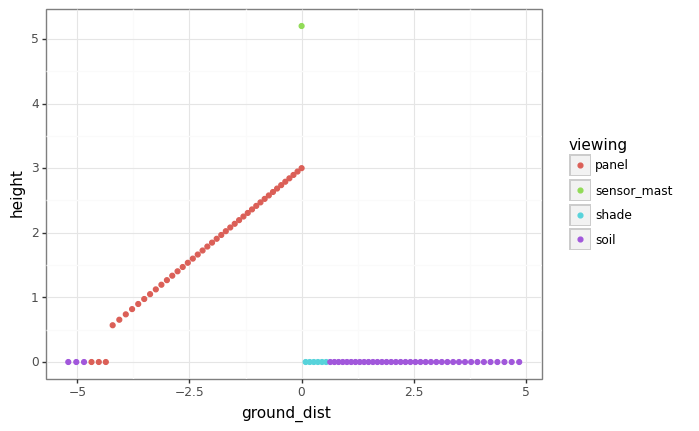

<ggplot: (114197348843)>


In [28]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 5.2        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 90 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,39,46.428571
1,shade,5,5.952381
2,soil,40,47.619048


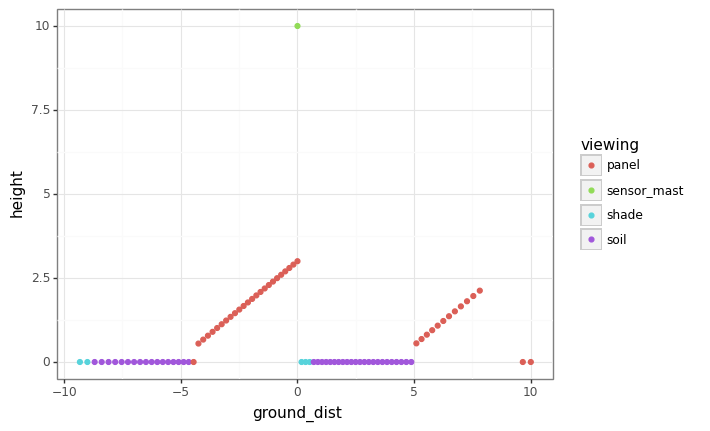

<ggplot: (114197289015)>


In [27]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 10        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 90 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,65,55.555556
1,shade,5,4.273504
2,soil,47,40.170940


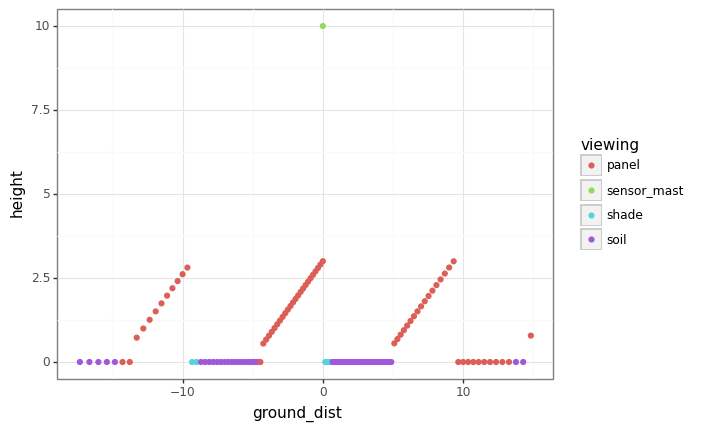

<ggplot: (114197396363)>


In [29]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 10        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 120 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,51,45.535714
1,shade,7,6.250000
2,soil,54,48.214286


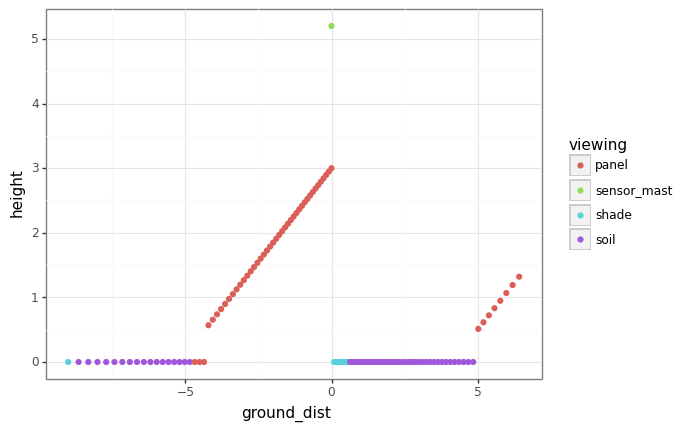

<ggplot: (114197448611)>


In [30]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 5.2        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 120 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,71,49.650350
1,shade,7,4.895105
2,soil,54,37.762238
3,under_panel,11,7.692308


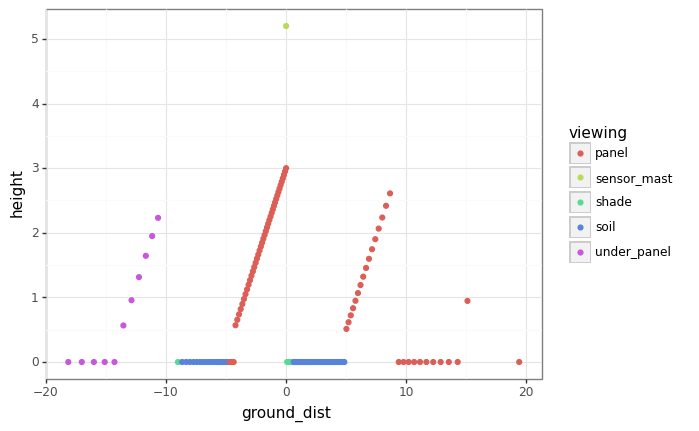

<ggplot: (114197558366)>


In [31]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 5.2        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 150 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,51,45.535714
1,shade,7,6.250000
2,soil,54,48.214286


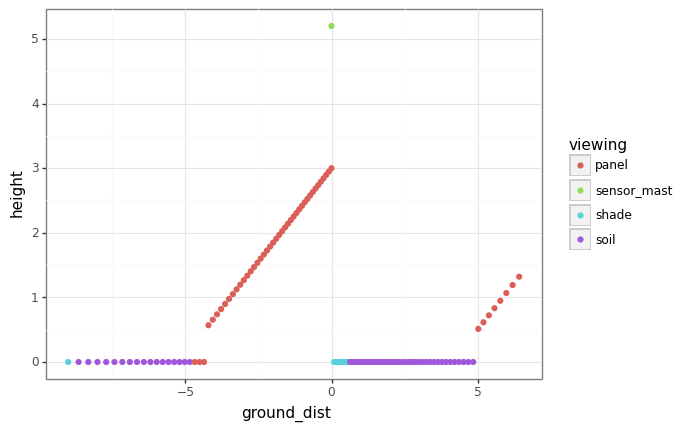

<ggplot: (114197417156)>


In [32]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 5.2        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 120 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

<ipython-input-26-24ba8336e4a0>:71: RuntimeWarning: invalid value encountered in double_scalars
<ipython-input-26-24ba8336e4a0>:86: RuntimeWarning: invalid value encountered in double_scalars


,viewing,n,percentage
0,panel,67,51.937984
1,shade,7,5.426357
2,soil,54,41.860465
3,under_panel,1,0.775194


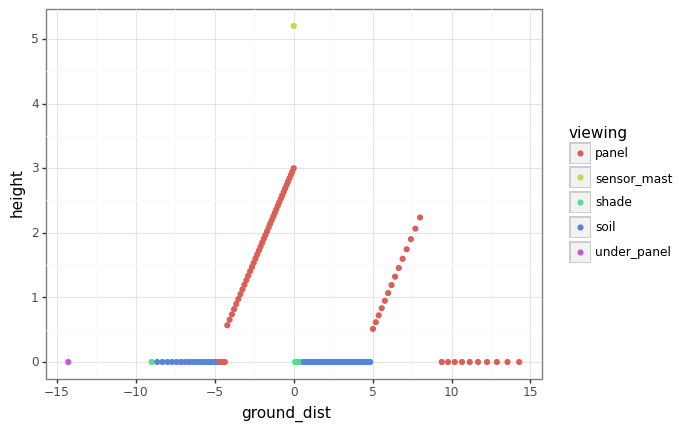

<ggplot: (114197342386)>


In [33]:
# Settings
#----------
#5.2 m (spring), 4.2 m (autumn) and 4.5 m (summer)
# Mast with hemispherical sensor
h_m      = 5.2        # Mast height (m)
# But we want 5m above PV panels!
sensor_viewing_angle = 140 # °

# step-size
steps = 0.5 # ° of viewing angle

ground_df = create_ground_df(h_m, 1, sensor_viewing_angle)

# Plot the ground truth
mast_df = pd.DataFrame(data=[[0, h_m, np.nan, 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([ground_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='ground_class'))
plt = plt + theme_bw()
#print(plt)

# Check what the sensor sees
viewing_df = check_interception_object(ground_df)
#display(viewing_df)

# Calculate percentages
display(calculate_viewing_percentages(viewing_df))

# Plot what the sensor sees
mast_df = pd.DataFrame(data=[[0, h_m, 'sensor_mast', 'sensor_mast']],
                      columns=['ground_dist', 'height', 'viewing', 'ground_class'])
graph_df = pd.concat([viewing_df, mast_df])
plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='ground_dist', y='height', colour='viewing'))
plt = plt + theme_bw()
print(plt)

In [34]:
51.9*0.05 + 41.8*0.37 + 5.4*(0.15*0.37)

18.3607

In [35]:
48.3*0.05 + 44.9*0.37 + 6.7*(0.15*0.37)

19.399849999999997